In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
data_dir = 'D:/University/Spring-2024/Traffic Sign Classification/DATA'

In [3]:
batch_size = 32
img_height = 180
img_width = 180

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 4170 files belonging to 58 classes.
Using 3336 files for training.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 4170 files belonging to 58 classes.
Using 834 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['Bicycles crossing', 'Bicycles crossing 2', 'Children crossing', 'Danger Ahead', 'Dangerous curve to the left', 'Dangerous curve to the right', 'Dont Go Left', 'Dont Go Left or Right', 'Dont Go Right', 'Dont Go straight', 'Dont Go straight or Right', 'Dont Go straight or left', 'Dont overtake from Left', 'Fences', 'Give Way', 'Go Left', 'Go Left or right', 'Go Right', 'Go left or straight', 'Go right or straight', 'Go straight', 'Go straight or right', 'Heavy Vehicle Accidents', 'Horn', 'No Car', 'No Entry', 'No Uturn', 'No horn', 'No stopping', 'Road Divider', 'Roundabout mandatory', 'Speed limit 15 kmh', 'Speed limit 30 kmh', 'Speed limit 40 kmh', 'Speed limit 40 kmh 2', 'Speed limit 5 kmh', 'Speed limit 50 kmh', 'Speed limit 50 kmh 2', 'Speed limit 60 kmh', 'Speed limit 70 kmh', 'Speed limit 80 kmh', 'Traffic signals', 'Train Crossing', 'Under Construction', 'Unknown 1', 'Unknown 2', 'Unknown 3', 'Unknown 4', 'Unknown 5', 'Unknown 6', 'Unknown 7', 'Unknown 8', 'Uturn', 'Zebra Cross

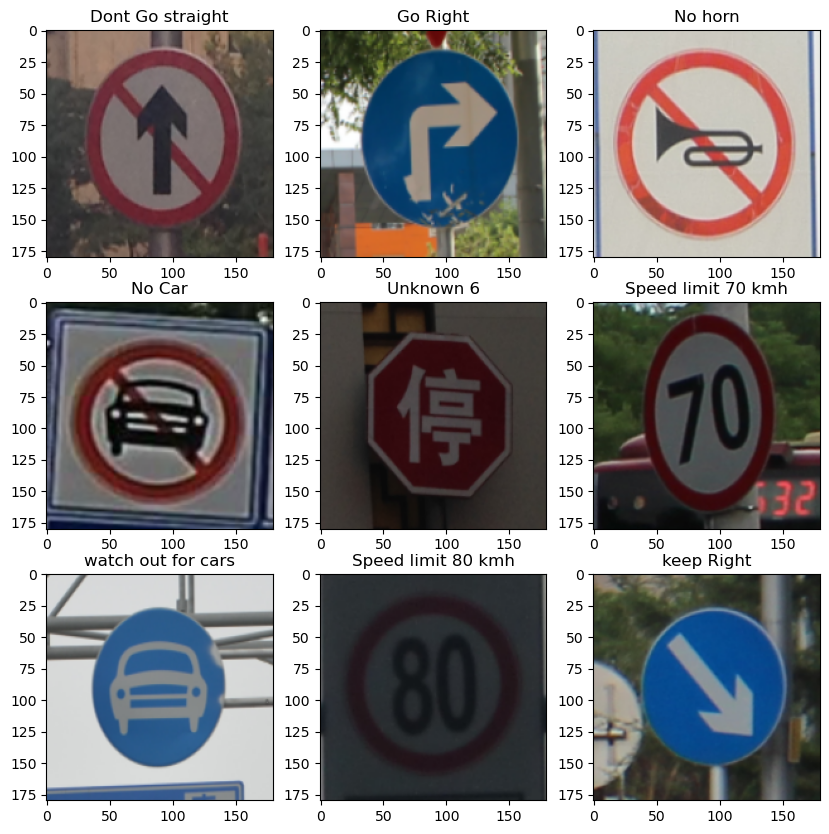

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("on")

In [8]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
normalization_layer = layers.Rescaling(1./255)

In [11]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
print(np.min(image_batch), np.max(image_batch))

0.0 1.0


In [12]:

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
) 

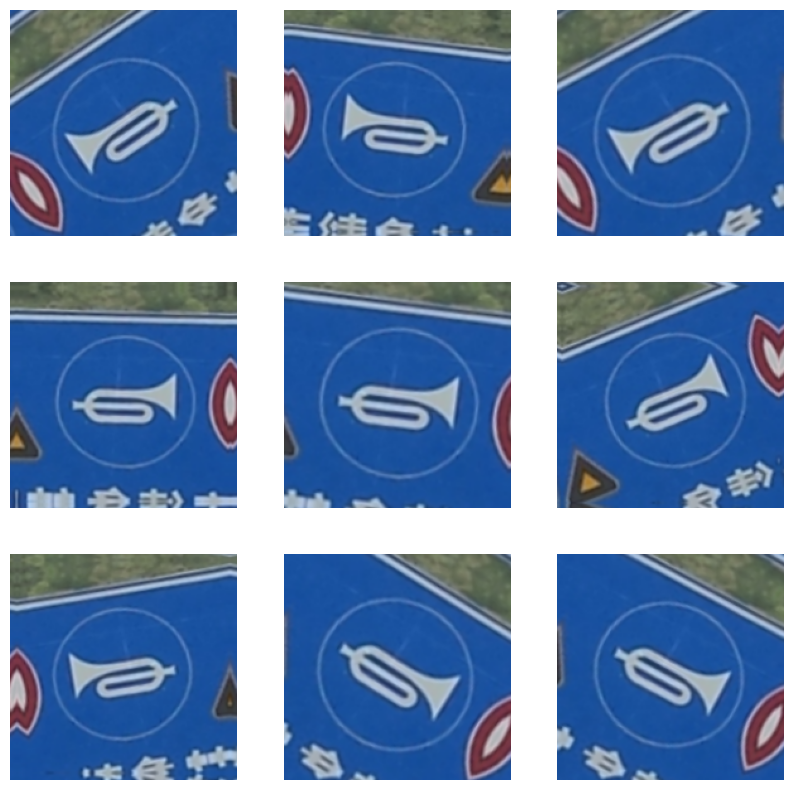

In [13]:

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


In [14]:
num_classes = len(class_names)

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),  # Rescale pixel values to [0, 1]
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),   # Add dropout for regularization
    layers.Flatten(),       # Flatten for the dense layers
    layers.Dense(128, activation='relu'),  
    layers.Dense(num_classes),                # No activation on the last layer
    layers.Activation('softmax', name="outputs")  # Explicit softmax layer
])


In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [17]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30



D:\DeepLearning\anaconda3\Lib\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(



105/105 [==============================] - 17s 145ms/step - loss: 2.3973 - accuracy: 0.3795 - val_loss: 1.7566 - val_accuracy: 0.5048
Epoch 2/30
105/105 [==============================] - 15s 141ms/step - loss: 1.2966 - accuracy: 0.6202 - val_loss: 0.9706 - val_accuracy: 0.7338
Epoch 3/30
105/105 [==============================] - 15s 141ms/step - loss: 0.8247 - accuracy: 0.7470 - val_loss: 0.7443 - val_accuracy: 0.8046
Epoch 4/30
105/105 [==============================] - 15s 141ms/step - loss: 0.5664 - accuracy: 0.8219 - val_loss: 0.5097 - val_accuracy: 0.8597
Epoch 5/30
105/105 [==============================] - 15s 143ms/step - loss: 0.4460 - accuracy: 0.8723 - val_loss: 0.4659 - val_accuracy: 0.8729
Epoch 6/30
105/105 [==============================] - 15s 141ms/step - loss: 0.3312 - accuracy: 0.8966 - val_loss: 0.2983 - val_accuracy: 0.9317
Epoch 7/30
105/105 [==============================] - 15s 141ms/step - loss: 0.2958 - accuracy: 0.9077 - val_loss: 0.2923 - val_accuracy: 0.

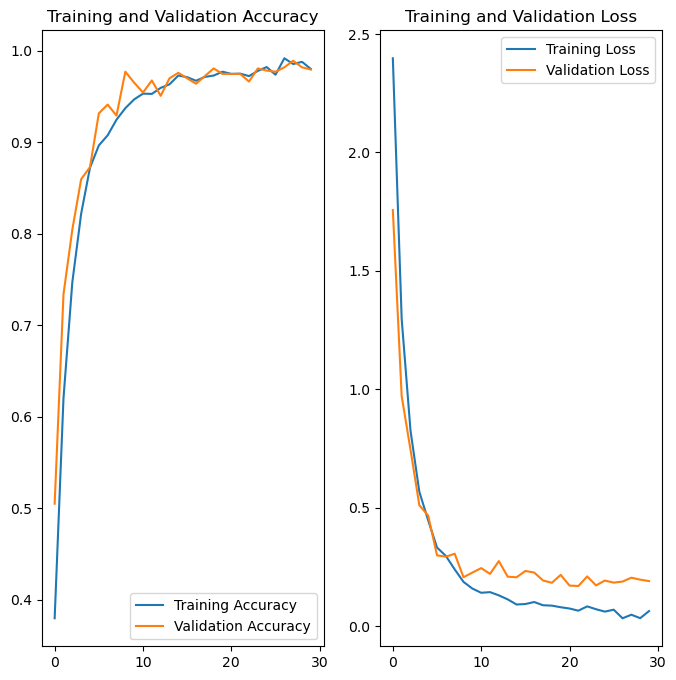

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()